In [1]:
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities, _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib import animation, rc
%matplotlib inline
rc('animation', html='html5')

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy
from IPython.display import HTML
import Utils.TSNEext as tsneExt

In [2]:
np.core.arrayprint._line_width = 160

In [3]:
digits = load_digits()

In [4]:
digits.images[3]

array([[  0.,   0.,   7.,  15.,  13.,   1.,   0.,   0.],
       [  0.,   8.,  13.,   6.,  15.,   4.,   0.,   0.],
       [  0.,   2.,   1.,  13.,  13.,   0.,   0.,   0.],
       [  0.,   0.,   2.,  15.,  11.,   1.,   0.,   0.],
       [  0.,   0.,   0.,   1.,  12.,  12.,   1.,   0.],
       [  0.,   0.,   0.,   0.,   1.,  10.,   8.,   0.],
       [  0.,   0.,   8.,   4.,   5.,  14.,   9.,   0.],
       [  0.,   0.,   7.,  13.,  13.,   9.,   0.,   0.]])

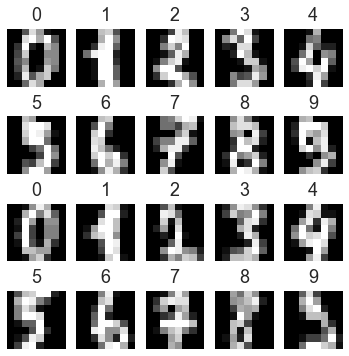

In [5]:
nrows, ncols = 4, 5
plt.figure(figsize=(6,6))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])
plt.savefig('digits.png', dpi=150)

In [6]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])

In [7]:
digits_proj = TSNE(random_state=RS).fit_transform(X)

In [8]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

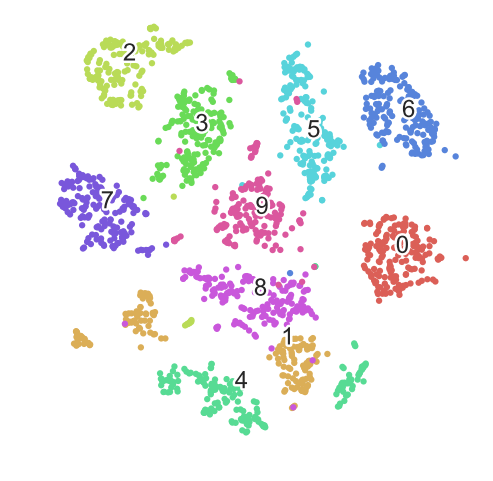

In [9]:
scatter(digits_proj, y)
plt.savefig('digits_tsne.png', dpi=120)

In [10]:
def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P

In [11]:
# Pairwise distances between all data points.
D = pairwise_distances(X, squared=True)
# Similarity with constant sigma.
P_constant = _joint_probabilities_constant_sigma(D, .002)
# Similarity with variable sigma.
P_binary = _joint_probabilities(D, 30., False)
# The output of this function needs to be reshaped to a square matrix.
P_binary_s = squareform(P_binary)

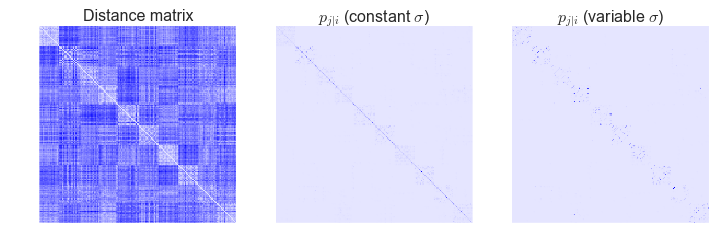

In [12]:
plt.figure(figsize=(12, 4))
pal = sns.light_palette("blue", as_cmap=True)

plt.subplot(131)
plt.imshow(D[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("Distance matrix", fontdict={'fontsize': 16})

plt.subplot(132)
plt.imshow(P_constant[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (constant $\sigma$)", fontdict={'fontsize': 16})

plt.subplot(133)
plt.imshow(P_binary_s[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (variable $\sigma$)", fontdict={'fontsize': 16})
plt.savefig('similarity.png', dpi=120)

In [18]:
backedGd, pps = tsneExt.useGd_Hist()

In [21]:
TSNE(random_state=RS).fit_transform(X)
X_iter = tsneExt.getHist(pps)
tsneExt.restorGd(backedGd)


[MoviePy] Building file animation.gif with imageio


100%|████████████████████████████████████████| 126/126 [00:08<00:00, 15.28it/s]


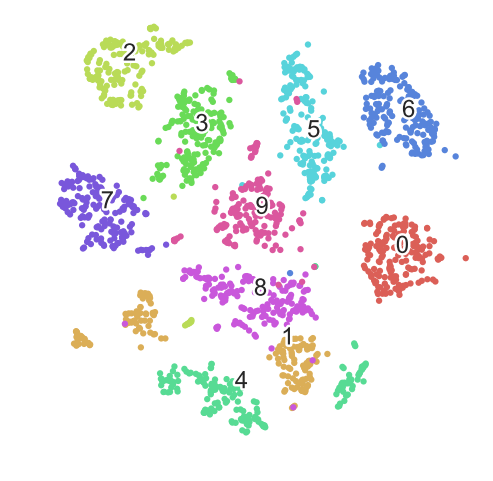

In [22]:
f, ax, sc, txts = scatter(X_iter[..., -1], y)

def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    for j, txt in zip(range(10), txts):
        xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

res = mpy.VideoClip(make_frame_mpl, duration=X_iter.shape[2]/40.).write_gif("animation.gif", fps=20)
HTML('<img src="animation.gif">')

In [19]:
pos = tsneExt.getPos()

In [20]:
len(pps)

0